# Pearson Residuals Example  
**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

In this notebook, we redo the demonstration of the [GPU End to End Notebook Part 1](01_demo_gpu_e2e.ipynb), the GPU-acceleration capabilities of rapids-SingleCell for efficient single-cell analysis, except we'll use Pearson Residuals to compare observed data to expected data.

As with the original End to End workflow noteboooks, this tutorial showcases how to leverage GPU computing to significantly speed up your analysis workflow.

This method makes high-performance single-cell analysis accessible through straightforward GPU integration, transforming traditionally time-consuming analyses into rapid workflows.

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

Let's start by creating our dataset.

In [3]:
import os
import anndata as ad
import wget
import scanpy as sc

url = 'https://exampledata.scverse.org/rapids-singlecell/dli_census.h5ad'
data_dir = "./h5"
output = data_dir+'/dli_census.h5ad'
if not os.path.exists(data_dir): # Check if h5 directory exists
    print('creating data directory')
    os.system('mkdir ./h5')
else:
    print(f'{data_dir} directory found')

if not os.path.isfile(output): # Check to see if we have our final output.  If it is there, get to the analysis!
    if not os.path.isfile(output): # as it's not there, let's see if we have our downloaded file.  If not, let's get it!
        print('Downloading cell data..')
        wget.download(url, output)
 
    adata = ad.read_h5ad(output)
    adata= adata[adata.obs["assay"].isin(["10x 3' v3", "10x 5' v1", "10x 5' v2"])].copy()
    adata.write(output) 
else:
    print(f'{output} dataset found')

./h5 directory found
./h5/dli_census.h5ad dataset found


We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read(output) #reads in ./h5/dli_census.h5ad

CPU times: user 6.17 s, sys: 201 ms, total: 6.37 s
Wall time: 6.37 s


In [6]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 93.6 ms, sys: 611 ms, total: 705 ms
Wall time: 704 ms


In [7]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 7.08978796005249


## Preprocessing

In [8]:
preprocess_start = time.time()

In [9]:
adata.var_names = adata.var.feature_name

### Quality Control

We calculate quality control (QC) metrics to assess cell and gene quality. These include:  

- **Per cell metrics**:  
  - Total counts per cell (library size)  
  - Number of detected genes per cell  
  - Percentage of counts from mitochondrial (`MT`) and ribosomal (`RIBO`) genes  

- **Per gene metrics** (gene space):  
  - Total counts per gene  
  - Number of cells expressing each gene  

These metrics help identify low-quality or stressed cells and ensure a meaningful feature set for downstream analysis.

In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 2.07 ms, sys: 9 μs, total: 2.08 ms
Wall time: 2.03 ms


In [11]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 1.73 ms, sys: 0 ns, total: 1.73 ms
Wall time: 1.68 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 33.7 ms, sys: 2.09 ms, total: 35.8 ms
Wall time: 35.7 ms


To visualize the quality control (QC) metrics, we generate the following plots:

1. **Scatter plot: Total counts vs. Mitochondrial percentage**  
   - This plot shows the relationship between the total UMI counts per cell and the percentage of mitochondrial (`MT`) gene expression.  
   - Cells with high mitochondrial percentages may indicate stressed or dying cells.

2. **Scatter plot: Total counts vs. Number of detected genes**  
   - This plot displays the correlation between the total UMI counts per cell and the number of detected genes.  
   - A strong correlation is expected, but outliers with low gene counts might indicate empty droplets or dead cells.

3. **Violin plot: Number of detected genes per cell**  
   - This violin plot visualizes the distribution of the number of detected genes per cell.  
   - It helps identify cells with abnormally low or high gene counts, which could be filtered out.

4. **Violin plot: Total counts per cell**  
   - This plot shows the distribution of total counts per cell, indicating library size variation.  
   - Extreme values may suggest low-quality or overly dominant cells.

5. **Violin plot: Percentage of mitochondrial counts per cell**  
   - This plot illustrates the distribution of mitochondrial gene expression across all cells.  
   - High mitochondrial content could be a sign of cell stress or apoptosis.

These visualizations help assess dataset quality and guide decisions on filtering low-quality cells.

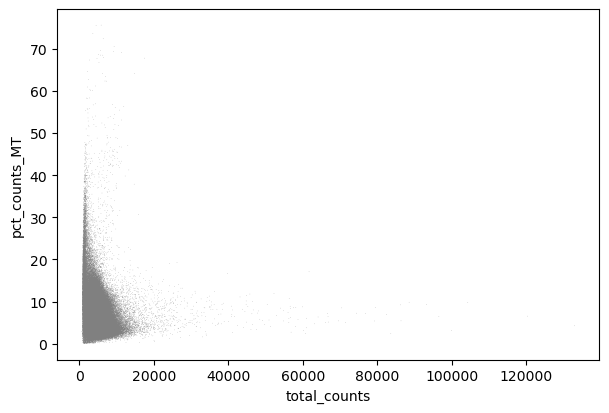

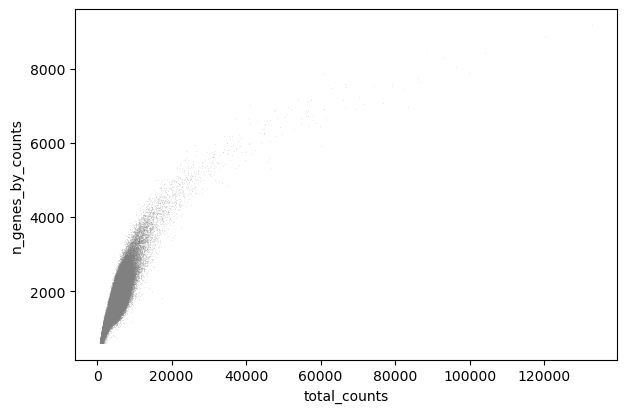

In [13]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

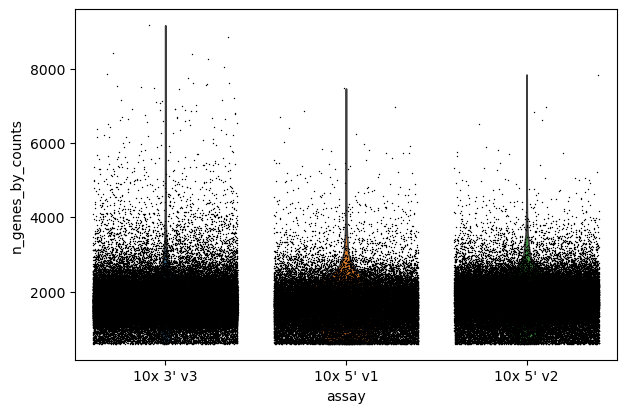

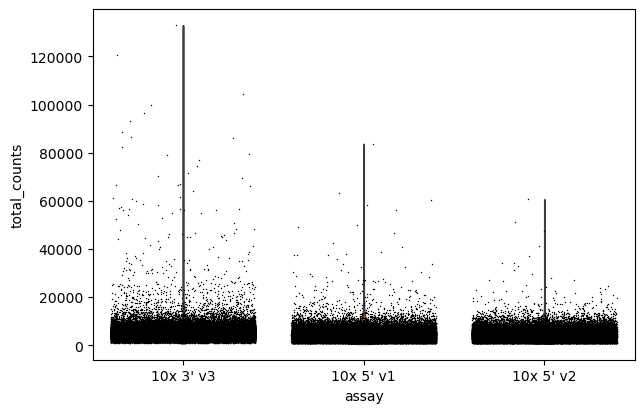

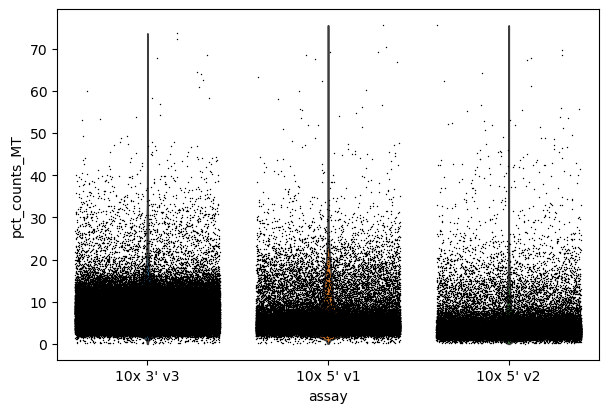

In [14]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="assay")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [15]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 180 ms, sys: 3.02 ms, total: 183 ms
Wall time: 182 ms


We also filter out genes that are expressed in less than 3 cells.

In [16]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

CPU times: user 199 ms, sys: 20 ms, total: 219 ms
Wall time: 218 ms


The size of our count matrix is now reduced.

In [17]:
adata.shape

(213081, 25430)

### Normalize

Before performing further transformations on the data, we store the **raw count matrix** in the `.layers` attribute.  
This ensures that the original unnormalized expression values remain accessible for later analyses.  


In [18]:
adata.layers["counts"] = adata.X.copy()

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 687 μs, sys: 0 ns, total: 687 μs
Wall time: 613 μs


Next, we data transform the count matrix.

In [20]:
%%time
rsc.pp.log1p(adata)

CPU times: user 312 μs, sys: 0 ns, total: 312 μs
Wall time: 248 μs


In [21]:
adata.raw = adata

### **Identifying Highly Variable Genes**  

Next, we identify **highly variable genes (HVGs)**, which capture the most biologically relevant variation in the dataset.  
These genes are selected based on their variance, helping to reduce noise and focus on meaningful signals.  

We use the **Pearson residuals** method to detect HVGs while preserving statistical robustness


In [22]:
%%time
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="pearson_residuals", layer="counts"
)

CPU times: user 1.69 s, sys: 81.1 ms, total: 1.77 s
Wall time: 1.77 s


Now we restrict our AnnData object to the highly variable genes.

In [23]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 323 ms, sys: 251 ms, total: 574 ms
Wall time: 573 ms


In [24]:
adata.shape

(213081, 5000)

### Normalize Pearson residuals
To correct for technical biases and overdispersion in single-cell data,  
we apply **Pearson residual normalization**, a method that stabilizes variance across genes.  

This transformation enhances the detection of biological variation while reducing noise.  
We store the **Pearson residuals** in a separate layer to preserve the original data:  

In [25]:
%%time
adata.layers["pearson_residuals"] = rsc.pp.normalize_pearson_residuals(
    adata, layer="counts", inplace=False
)

CPU times: user 110 ms, sys: 2.01 ms, total: 112 ms
Wall time: 264 ms


### Performing PCA on Pearson Residuals  

To reduce the dimensionality of the dataset while preserving meaningful variation,  
we perform **Principal Component Analysis (PCA)** using the **Pearson residuals**.  
This approach ensures that **technical noise is minimized**, allowing better downstream analysis.  

We compute **100 principal components (PCs)** from the normalized data

In [26]:
%%time
rsc.pp.pca(adata, n_comps=100, layer="pearson_residuals")

CPU times: user 429 ms, sys: 45 ms, total: 474 ms
Wall time: 474 ms


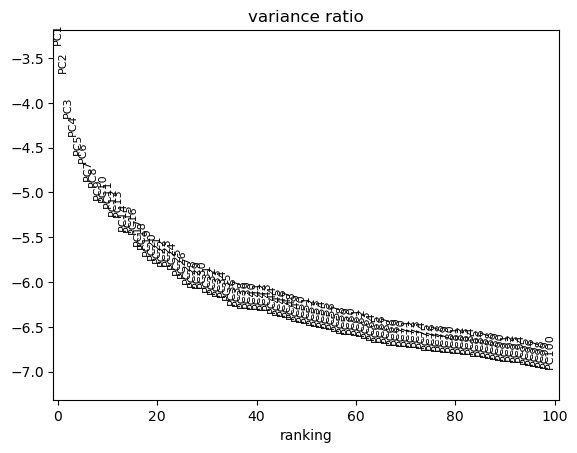

In [27]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [28]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 217 ms, sys: 267 ms, total: 485 ms
Wall time: 484 ms


In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 7.700944900512695


We have now finished the preprocessing of the data.

In [30]:
# These notebooks are very GPU memory intensive!
# In order to free up GPU memory, we'll kill this kernel prior to proceeding.  You will get a message.  This is expected.
# If you have a CUDA or an Out Of Memory (OOM) error, please kill all kernels to free up your GPU memory and try again!
# You can comment this out if you want to continue exploring the notebook.
# Please consult the README for more tips and tricks.

import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}